Epoch 1/50: 100%|██████████| 50/50 [00:04<00:00, 12.41it/s, loss=0.504]


Epoch 1 Summary: Test Acc: 0.8300


Epoch 2/50: 100%|██████████| 50/50 [00:03<00:00, 12.80it/s, loss=0.385] 


Epoch 2 Summary: Test Acc: 0.8725


Epoch 3/50: 100%|██████████| 50/50 [00:03<00:00, 14.07it/s, loss=0.303] 


Epoch 3 Summary: Test Acc: 0.8725


Epoch 4/50: 100%|██████████| 50/50 [00:03<00:00, 15.97it/s, loss=0.26]  


Epoch 4 Summary: Test Acc: 0.8825


Epoch 5/50: 100%|██████████| 50/50 [00:03<00:00, 16.57it/s, loss=0.241] 


Epoch 5 Summary: Test Acc: 0.8875


Epoch 6/50: 100%|██████████| 50/50 [00:03<00:00, 13.05it/s, loss=0.192] 


Epoch 6 Summary: Test Acc: 0.9125


Epoch 7/50: 100%|██████████| 50/50 [00:03<00:00, 14.92it/s, loss=0.166] 


Epoch 7 Summary: Test Acc: 0.9050


Epoch 8/50: 100%|██████████| 50/50 [00:03<00:00, 14.54it/s, loss=0.133] 


Epoch 8 Summary: Test Acc: 0.9225


Epoch 9/50: 100%|██████████| 50/50 [00:03<00:00, 15.15it/s, loss=0.133] 


Epoch 9 Summary: Test Acc: 0.9275


Epoch 10/50: 100%|██████████| 50/50 [00:03<00:00, 13.64it/s, loss=0.115] 


Epoch 10 Summary: Test Acc: 0.9200


Epoch 11/50: 100%|██████████| 50/50 [00:03<00:00, 13.22it/s, loss=0.0944]


Epoch 11 Summary: Test Acc: 0.9325


Epoch 12/50: 100%|██████████| 50/50 [00:03<00:00, 12.59it/s, loss=0.075] 


Epoch 12 Summary: Test Acc: 0.9250


Epoch 13/50: 100%|██████████| 50/50 [00:03<00:00, 12.64it/s, loss=0.0724]


Epoch 13 Summary: Test Acc: 0.9250


Epoch 14/50: 100%|██████████| 50/50 [00:04<00:00, 11.92it/s, loss=0.0437]


Epoch 14 Summary: Test Acc: 0.9275


Epoch 15/50: 100%|██████████| 50/50 [00:04<00:00, 12.50it/s, loss=0.0417] 


Epoch 15 Summary: Test Acc: 0.9350


Epoch 16/50: 100%|██████████| 50/50 [00:04<00:00, 12.34it/s, loss=0.0344]


Epoch 16 Summary: Test Acc: 0.9300


Epoch 17/50: 100%|██████████| 50/50 [00:04<00:00, 12.00it/s, loss=0.0477] 


Epoch 17 Summary: Test Acc: 0.9150


Epoch 18/50: 100%|██████████| 50/50 [00:04<00:00, 11.93it/s, loss=0.0397] 


Epoch 18 Summary: Test Acc: 0.9125


Epoch 19/50: 100%|██████████| 50/50 [00:04<00:00, 12.15it/s, loss=0.041]  


Epoch 19 Summary: Test Acc: 0.9150


Epoch 20/50: 100%|██████████| 50/50 [00:04<00:00, 11.89it/s, loss=0.0109] 


Epoch 20 Summary: Test Acc: 0.9250
Early stopping triggered.


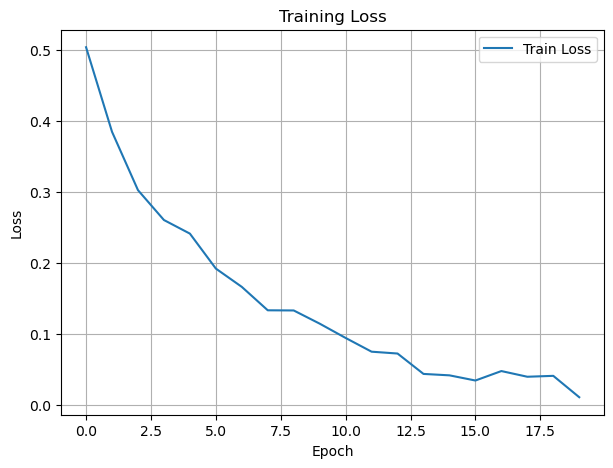

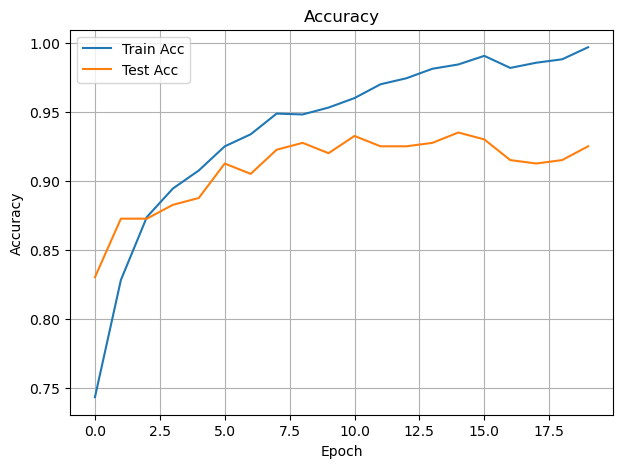

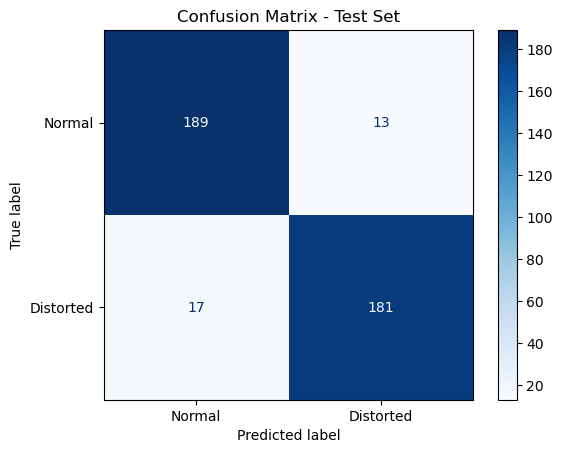

              precision    recall  f1-score   support

      Normal       0.92      0.94      0.93       202
   Distorted       0.93      0.91      0.92       198

    accuracy                           0.93       400
   macro avg       0.93      0.92      0.92       400
weighted avg       0.93      0.93      0.92       400

success


In [11]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# ==========================================
# 1. Path Definitions
# ==========================================
data_base_path = "Dataset for Binary Classification"
normal_dir = os.path.join(data_base_path, "normal_30x30_dataset")
distorted_dir = os.path.join(data_base_path, "distorted_30x30_dataset")

# ==========================================
# 2. Dataset Definition
# ==========================================
class LocalBinaryDataset(Dataset):
    def __init__(self, normal_path, distorted_path, transform=None):
        self.samples = []
        self.transform = transform
        if os.path.exists(normal_path):
            for f in os.listdir(normal_path):
                if f.lower().endswith('.png'):
                    self.samples.append((os.path.join(normal_path, f), 0))
        if os.path.exists(distorted_path):
            for f in os.listdir(distorted_path):
                if f.lower().endswith('.png'):
                    self.samples.append((os.path.join(distorted_path, f), 1))
    def __len__(self): return len(self.samples)
    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert("RGB")
        if self.transform: img = self.transform(img)
        return img, label

# ==========================================
# 3. Data Loader Preparation
# ==========================================
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

full_dataset = LocalBinaryDataset(normal_dir, distorted_dir, transform=transform)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_ds, test_ds = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

# ==========================================
# 4. Model Architecture
# ==========================================
class ArtifactCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 3 * 3, 256), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(256, 2)
        )
    def forward(self, x): return self.classifier(self.features(x))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ArtifactCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ==========================================
# 5. raining Loop with Logging for Graphs
# ==========================================
epochs = 50
best_acc = 0
patience = 5
counter = 0

train_losses, train_accs, test_accs = [], [], []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
    for imgs, labels in loop:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, pred = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (pred == labels).sum().item()
        loop.set_postfix(loss=running_loss/len(train_loader))


    train_losses.append(running_loss/len(train_loader))
    train_accs.append(correct_train/total_train)

    
    model.eval()
    correct_test = 0
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, pred = torch.max(outputs, 1)
            correct_test += (pred == labels).sum().item()
    
    accuracy = correct_test / len(test_ds)
    test_accs.append(accuracy)
    print(f"Epoch {epoch+1} Summary: Test Acc: {accuracy:.4f}")

    if accuracy > best_acc:
        best_acc = accuracy
        torch.save(model.state_dict(), "best_binary_model.pth")
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

# ==========================================
# 6. Graphs + Confusion Matrix
# ==========================================
plt.figure(figsize=(7,5))
plt.plot(train_losses, label="Train Loss")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(7,5))
plt.plot(train_accs, label="Train Acc")
plt.plot(test_accs, label="Test Acc")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.show()

# Confusion Matrix
all_labels, all_preds = [], []
model.eval()
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        _, pred = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(pred.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=["Normal", "Distorted"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Test Set")
plt.show()

print(classification_report(all_labels, all_preds, target_names=["Normal", "Distorted"]))
print("success")